In [1]:
from util.trajectories import *
from util.guided_ot import *
from util.simplicial_paths import *
import networkx as nx

# Functions

In [2]:
def dijkstra_tree(SC, best_path, other_paths, ref_path_class, colors=['green', 'red', 'blue'], plot_others=False, figsize=(5,5)):
    shortest_class = Trajectory_Class(SC)
    shortest_class.add_path(best_path)
    other_class = Trajectory_Class(SC)

    for path in other_paths:
        other_class.add_path(path)

    holder = Trajectory_Holder(SC)

    if plot_others:
        holder.add_class(other_class, None, 'others', colors[0])
        
    holder.add_class(ref_path_class, None, 'reference', colors[1])
    holder.add_class(shortest_class, None, 'result', colors[2])

    holder.plot_paths(True, figsize=figsize)
    holder.plot_projections(figsize=figsize)
    plt.show()

    return holder


def plot_bases(SC, extra):
    node_pos = {i:SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0])}
    num_bases = (SC.H.shape[0] + extra) if (extra > 0) else SC.H.shape[0]
    for i in range(num_bases):
        harm_vec = SC.H_extra[i,:]
        harm_vec_sign = np.sign(harm_vec)
        harm_vec_weight = np.abs(harm_vec)
        G = SC.graph
        GG = nx.DiGraph()
        G_oriented = nx.DiGraph()
        j = 0
        for k, edge in enumerate(SC.edges):
            if not SC.edge_vec[k]:
                continue
            sign, weight = harm_vec_sign[j], harm_vec_weight[j] * 10
            oriented_edge = (edge[0], edge[1]) if (sign > 0) else (edge[1], edge[0])
            G_oriented.add_edge(oriented_edge[0], oriented_edge[1], weight=weight)
            GG.add_edge(edge[0], edge[1], weight=weight)
            j += 1

        oriented_weights = [G_oriented[u][v]['weight'] for u,v in G_oriented.edges]

        plt.figure(figsize=(5,5))
        nx.draw(G_oriented, pos=node_pos, node_size=5, node_color='gray', width=oriented_weights, edge_color='black', arrows=True, arrowstyle="-|>", arrowsize=[8.5 * i for i in oriented_weights])
        plt.title(f"Basis corresponding to coordinate {i+1}")
        plt.show()


def backtrace(prev, start, end):
    node = end
    path = []
    while node != start:
        path.append(node)
        node = prev[node]
    path.append(node) 
    path.reverse()
    return path

def get_node_weights(path):
    return path.path_length

def get_path_proj_diff(path, ref_proj, norm_type=1):
    return np.linalg.norm(path.edge_projections - ref_proj, norm_type, axis=1)

def compute_costs(path, ref_proj, alpha, norm_type):
    edge_weights = np.hstack([np.array([0]), get_node_weights(path)])
    proj_diffs = get_path_proj_diff(path, ref_proj, norm_type)
    return edge_weights, proj_diffs, edge_weights + alpha * proj_diffs


def compare_path_perf(path1, path2, ref_proj, alpha, norm_type=1):
    num_nodes_path1, num_nodes_path2 = len(path1.nodes), len(path2.nodes)
    len_diff = np.abs(num_nodes_path1 - num_nodes_path2)
    shorter_path = np.argmin([ num_nodes_path1, num_nodes_path2 ])
    path1_costs = compute_costs(path1, ref_proj, alpha, norm_type)
    path2_costs = compute_costs(path2, ref_proj, alpha, norm_type)
    
    if len_diff == 0:
        return path1_costs, path2_costs
    elif shorter_path == 0:
        edge_cost = np.ones(num_nodes_path2) * path1_costs[0][-1]
        edge_cost[:num_nodes_path1] = path1_costs[0]

        proj_cost = np.ones(num_nodes_path2) * path1_costs[1][-1]
        proj_cost[:num_nodes_path1] = path1_costs[1]

        total_cost = np.ones(num_nodes_path2) * path1_costs[2][-1]
        total_cost[:num_nodes_path1] = path1_costs[2]

        path1_costs = edge_cost, proj_cost, total_cost
    else:
        edge_cost = np.ones(num_nodes_path1) * path2_costs[0][-1]
        edge_cost[:num_nodes_path2] = path2_costs[0]

        proj_cost = np.ones(num_nodes_path1) * path2_costs[1][-1]
        proj_cost[:num_nodes_path2] = path2_costs[1]

        total_cost = np.ones(num_nodes_path1) * path2_costs[2][-1]
        total_cost[:num_nodes_path2] = path2_costs[2]

        path2_costs = edge_cost, proj_cost, total_cost

    return path1_costs, path2_costs

def plot_cost_diffs(path1, path2, ref_path_proj, alpha, norm_type=1):
    path1_costs, path2_costs = compare_path_perf(path1, path2, ref_path_proj, alpha, norm_type)
    #print(path1_costs[0].shape, path1_costs[1].shape, path1_costs[2].shape)
    #print(path2_costs[0].shape, path2_costs[1].shape, path2_costs[2].shape)
    fig, ax = plt.subplots(3,1, figsize=(5,15))#,12))

    colors = ["red", "blue"]

    x_axis = np.arange(np.max([len(path1.nodes), len(path2.nodes)]))

    ax[0].plot(x_axis, path1_costs[0], color=colors[0], marker="+")
    ax[0].plot(x_axis, path2_costs[0], color=colors[1], marker="x")
    ax[0].set_xlabel('Path node')
    ax[0].set_ylabel('Edge weight sum')
    ax[0].legend(["reference path", "resulting path"])

    ax[1].plot(x_axis, path1_costs[1], color=colors[0], marker="1")
    ax[1].plot(x_axis, path2_costs[1], color=colors[1], marker="2")
    ax[1].set_xlabel('Path node')
    ax[1].set_ylabel('Projection difference')
    ax[1].legend(["reference path", "resulting path"])

    ax[2].plot(x_axis, path1_costs[2], color=colors[0], marker="*")
    ax[2].plot(x_axis, path2_costs[2], color=colors[1], marker="P")

    ax[2].set_xlabel('Path node')
    ax[2].set_ylabel('Total cost = edge weight sum + alpha * proj diff') 
    ax[2].legend(["reference path", "resulting path"])
    plt.show()

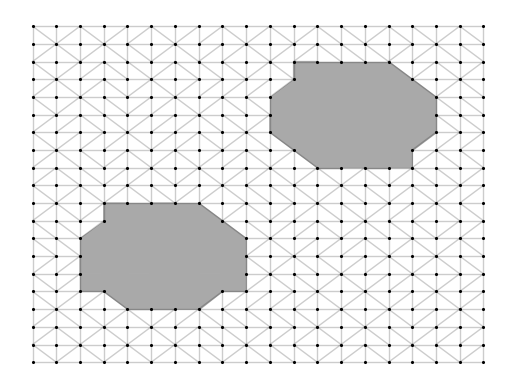

In [3]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

# Experiment 1: Extra is False

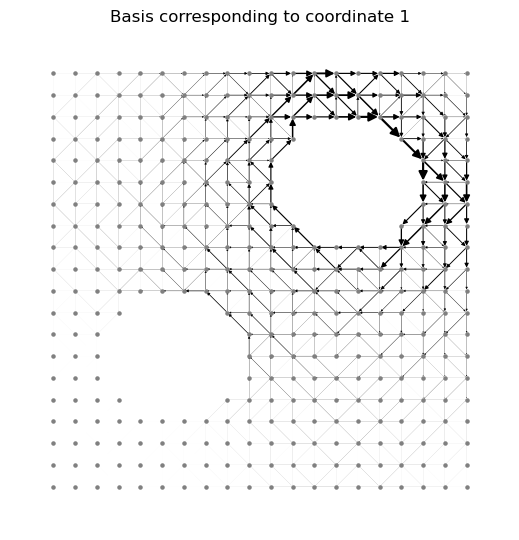

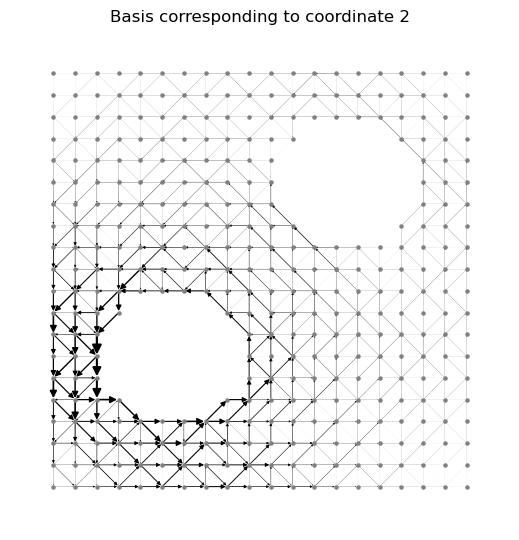

In [11]:
extra = 0
plot_bases(SC, extra)

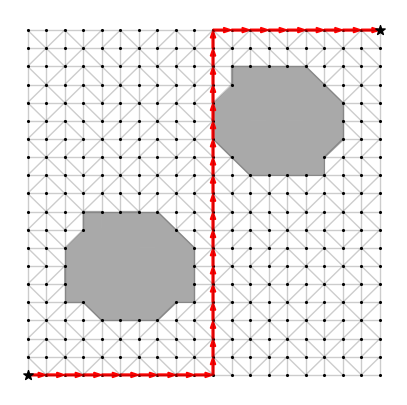

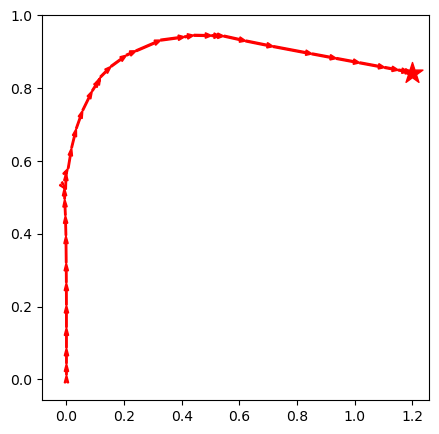

In [12]:
ref_path_coords = [(-1,-1), (0, -1), (0, 1), (1,1)]
num_paths, num_nodes = 1, 1

start, end = 0, len(SC.node_vec)-1

ref_path_class = Trajectory_Class(SC, extra)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_class.plot_paths('red', 'ref', figsize=(5,5))
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_projections('red', 'reference', figsize=(5,5))

ALPHA = 0
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)


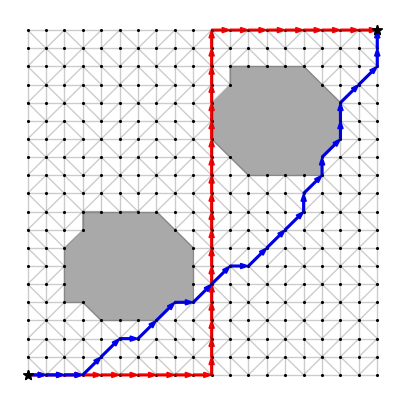

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


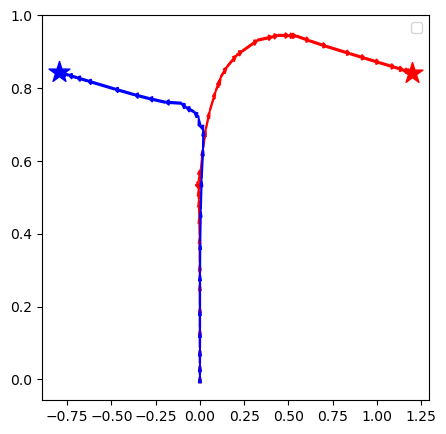

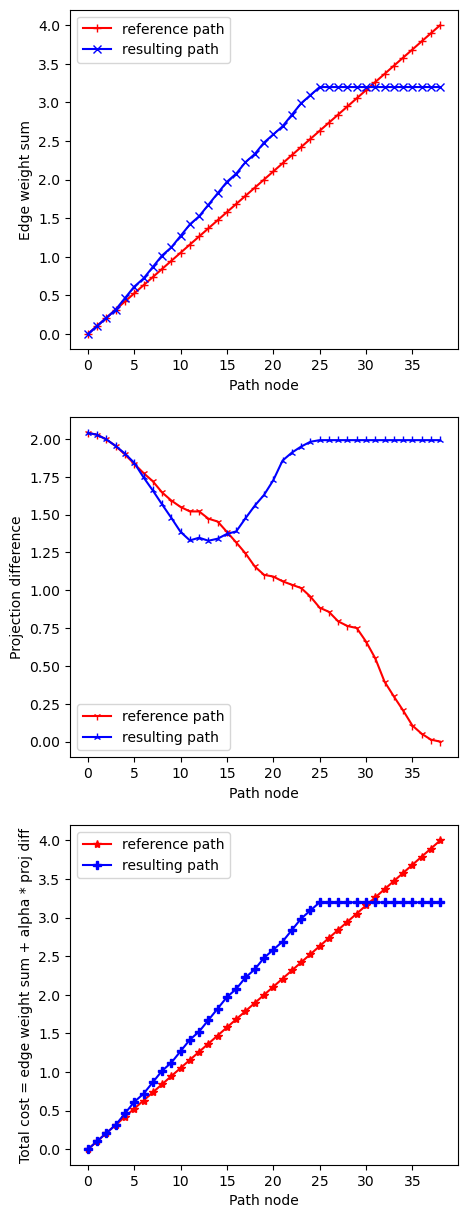

------------------------------------------------------------------------------------------
ALPHA = 1
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)

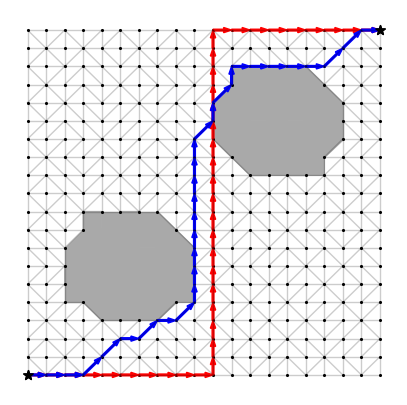

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


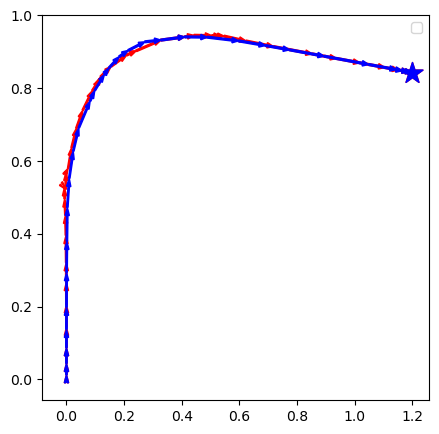

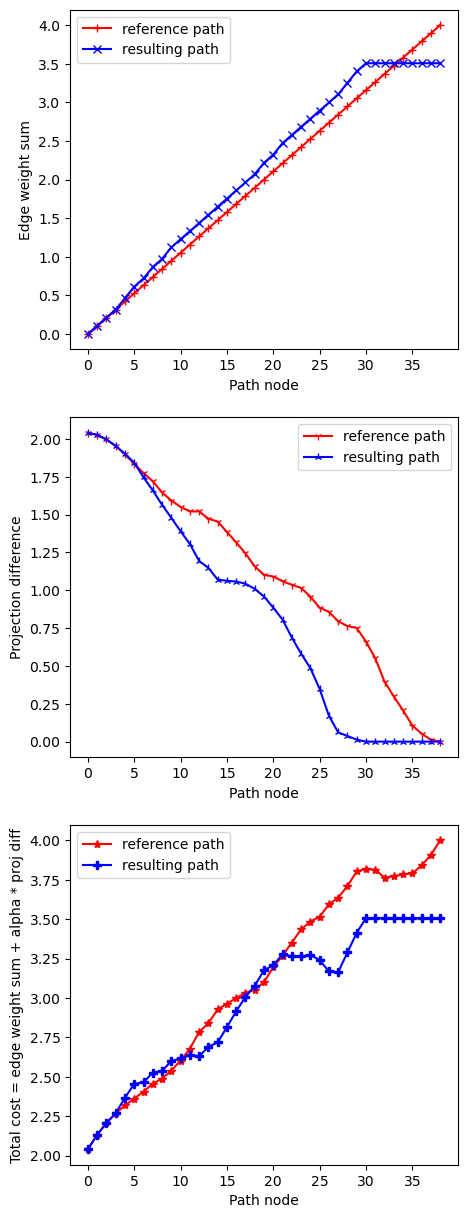

------------------------------------------------------------------------------------------
ALPHA = 5
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)

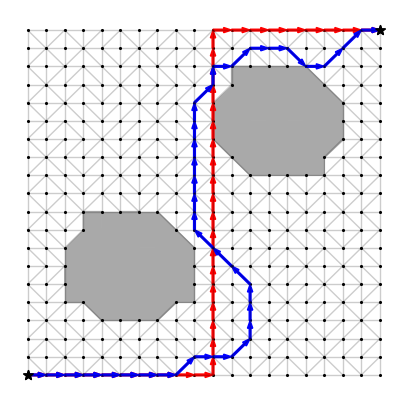

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


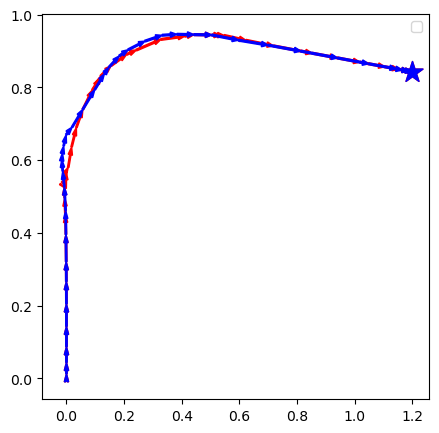

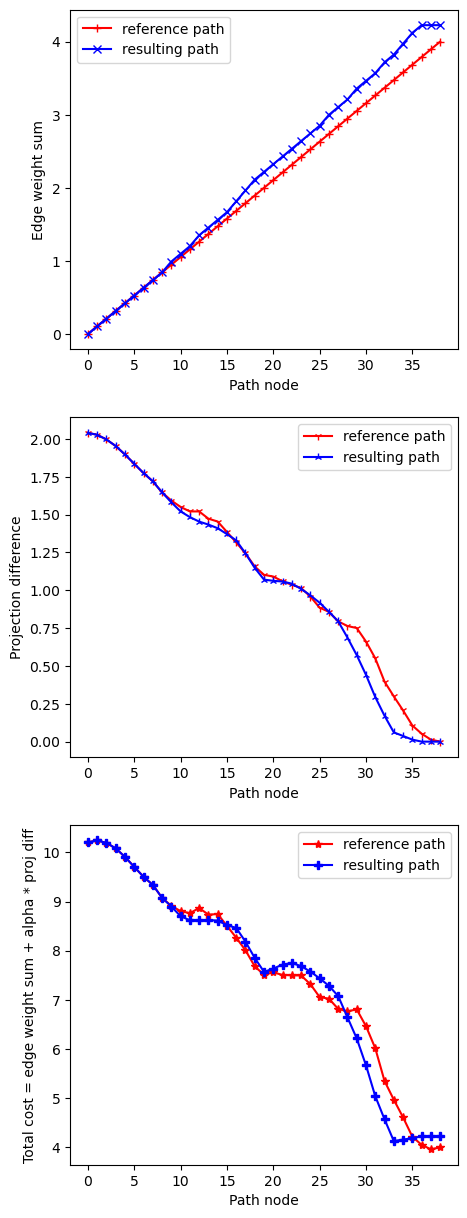

------------------------------------------------------------------------------------------
ALPHA = 10
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,

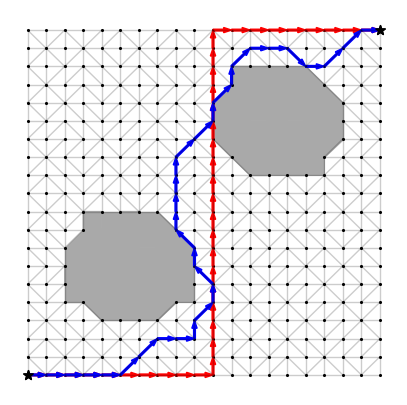

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


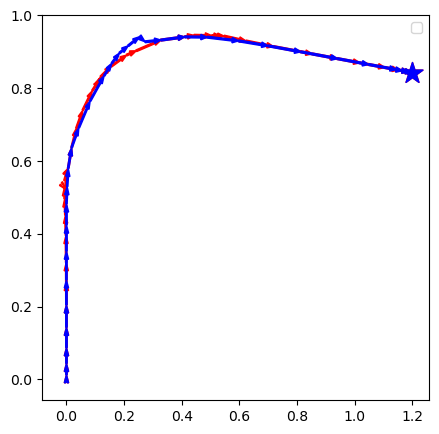

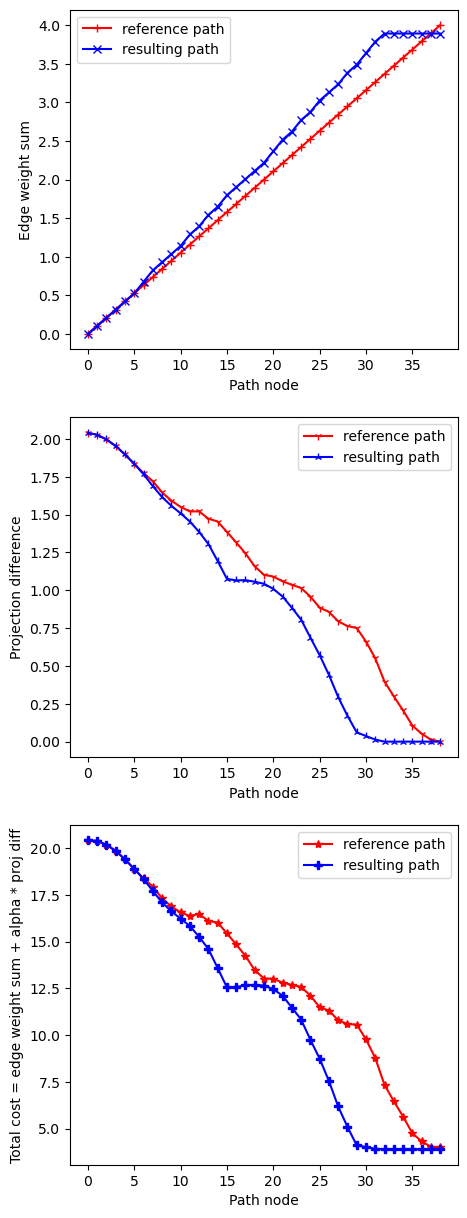

------------------------------------------------------------------------------------------
ALPHA = 100
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2,)
(2,) (2

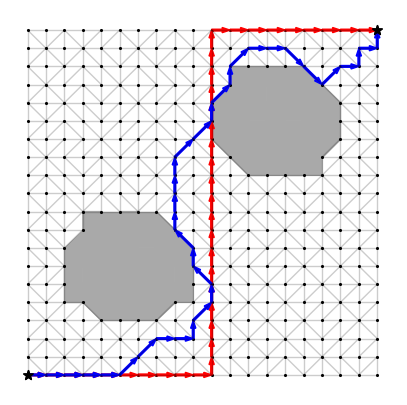

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


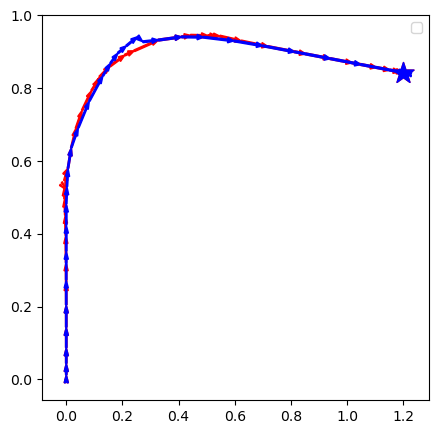

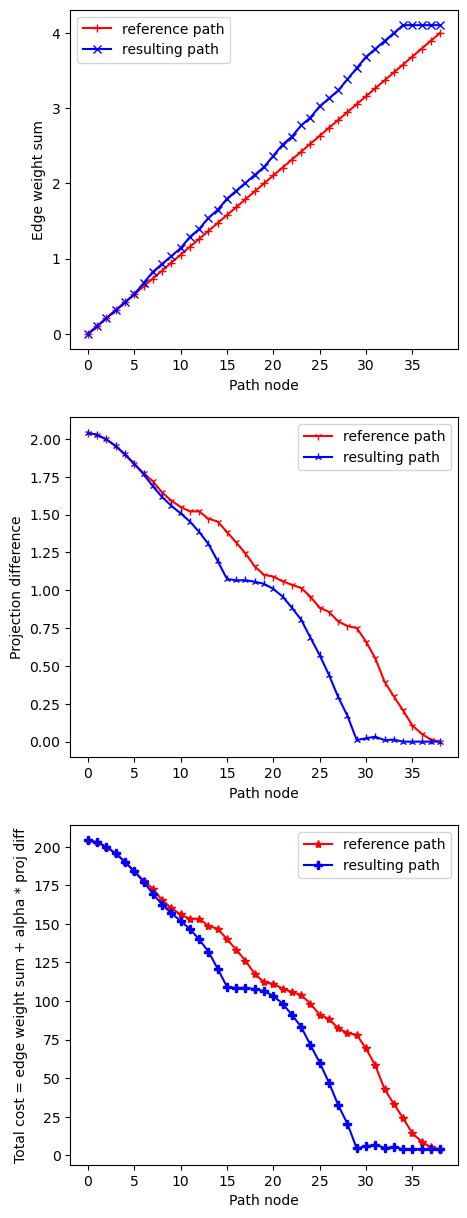

------------------------------------------------------------------------------------------


In [13]:
alphas = [0, 1, 5, 10, 100]

holders = []
for alpha in alphas:
        print(f"ALPHA = {alpha}")
        best_path, cost, prev, visit_order, other_paths = augmented_dijkstra(SC, start, end, ref_path_proj, alpha, False, extra)
        print(f"ref proj diff : {np.linalg.norm(ref_path_proj-best_path.edge_projections[-1],1)}")
        holder = dijkstra_tree(SC, best_path, other_paths, ref_path_class, plot_others=False)
        plot_cost_diffs(ref_path, best_path, ref_path_proj, alpha)
        print("---"*30)
        

# Experiment 2: Extra is true

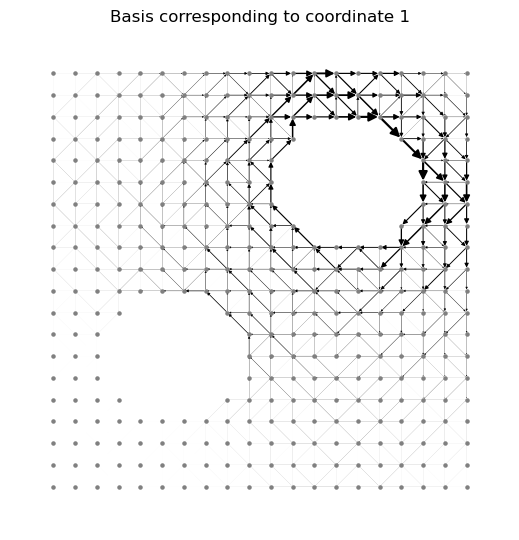

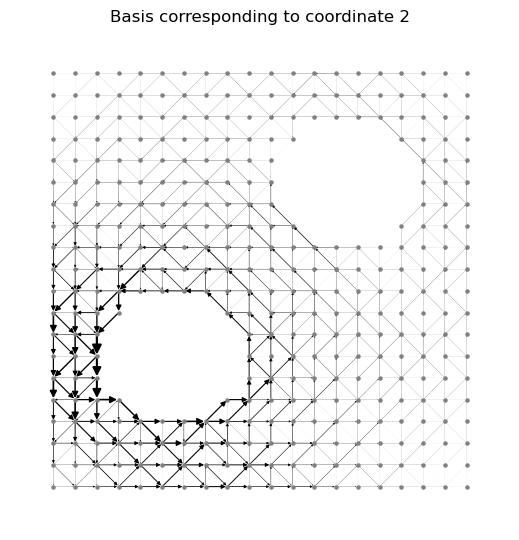

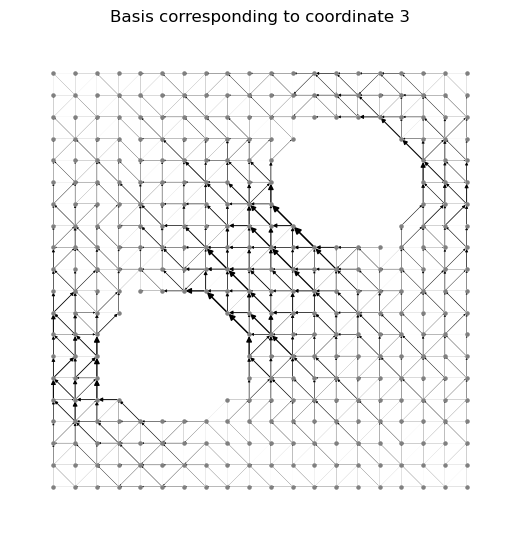

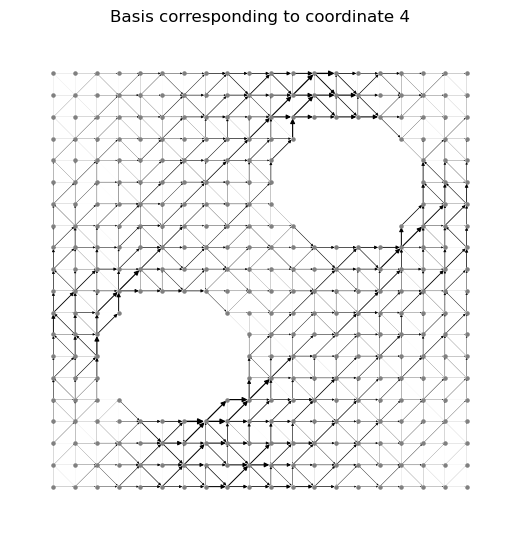

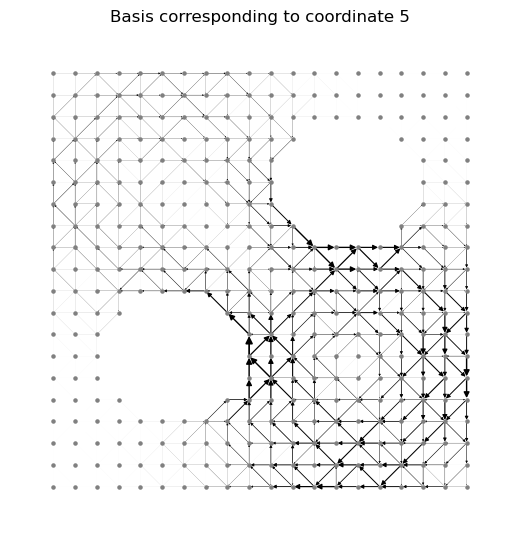

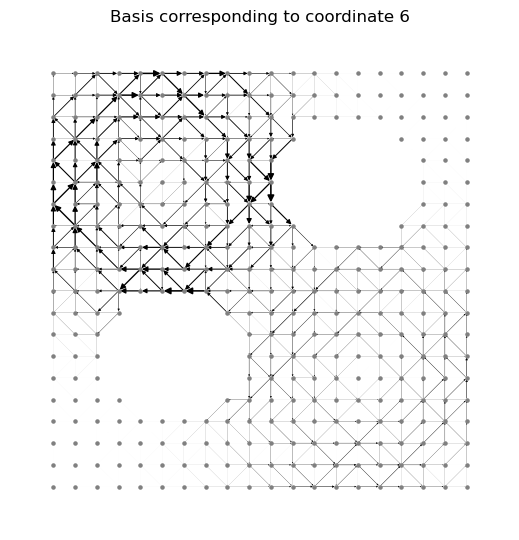

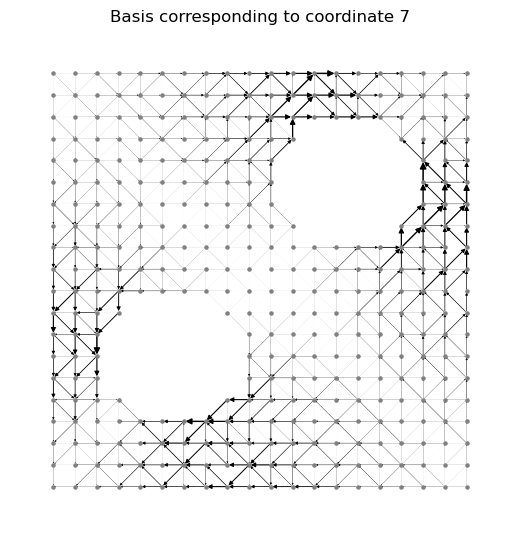

In [14]:
extra = 5
plot_bases(SC, extra)

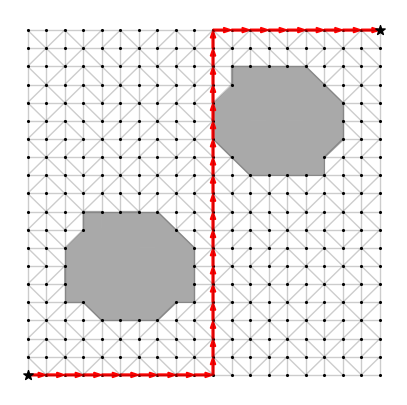

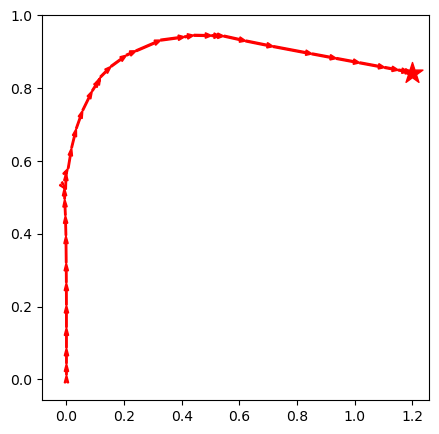

In [15]:
ref_path_coords = [(-1,-1), (0, -1), (0, 1), (1,1)]
num_paths, num_nodes = 1, 1

start, end = 0, len(SC.node_vec)-1

ref_path_class = Trajectory_Class(SC, extra)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_class.plot_paths('red', 'ref', figsize=(5,5))
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_projections('red', 'reference', figsize=(5,5))

ALPHA = 0
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)


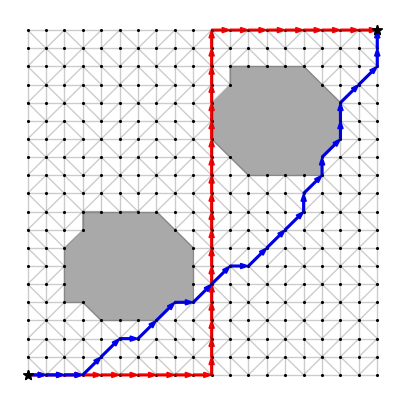

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


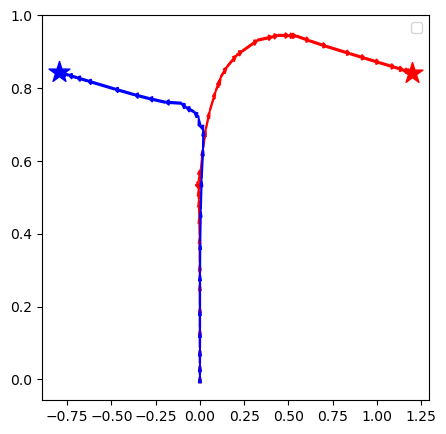

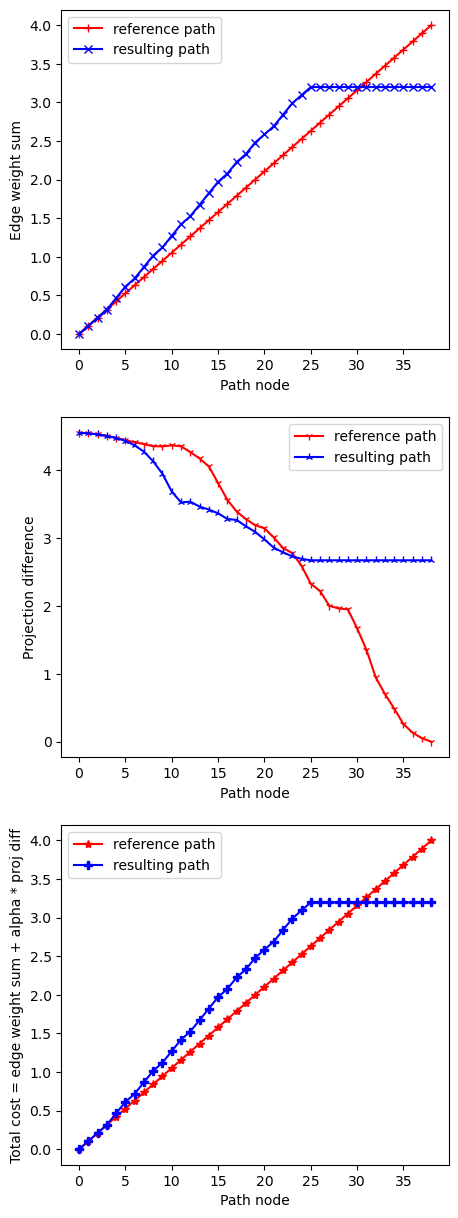

ALPHA = 1
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)


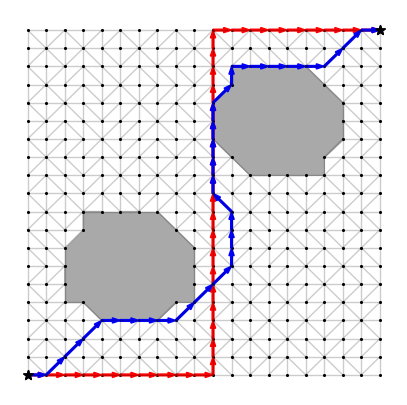

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


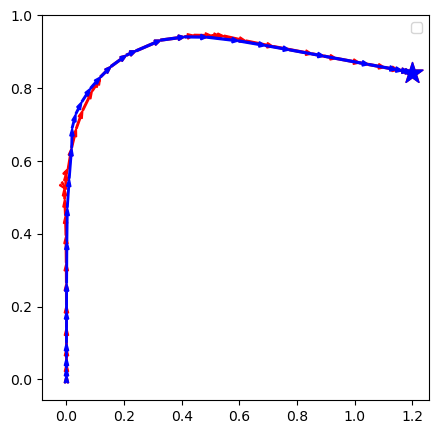

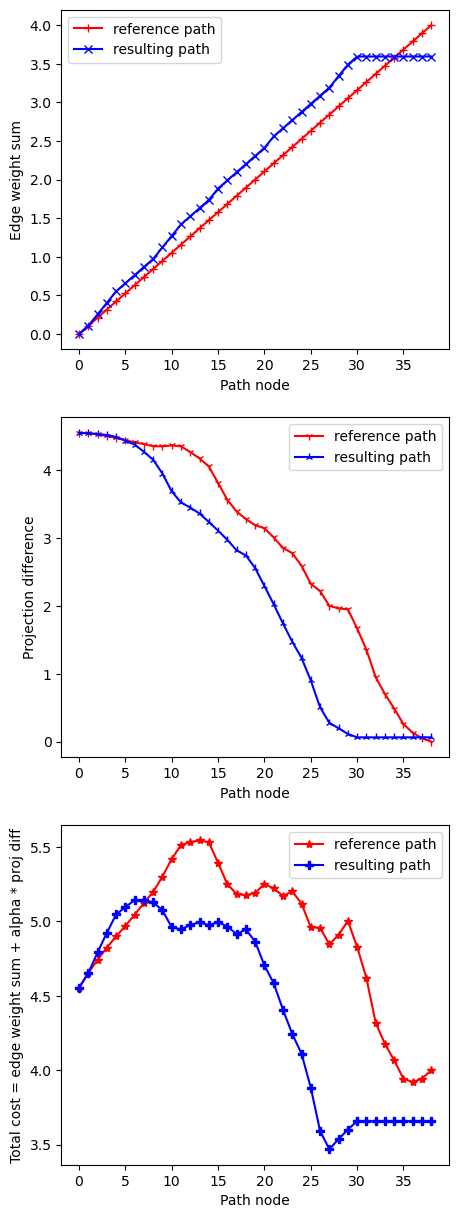

ALPHA = 5
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)


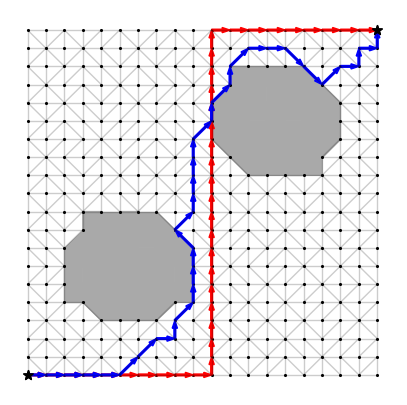

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


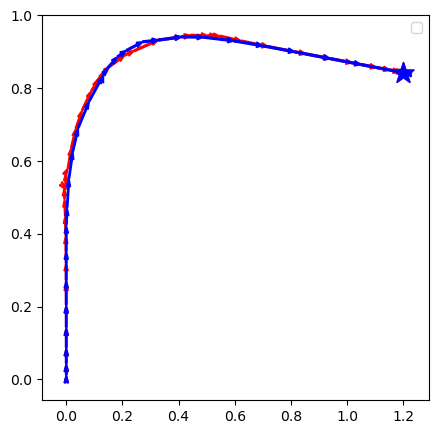

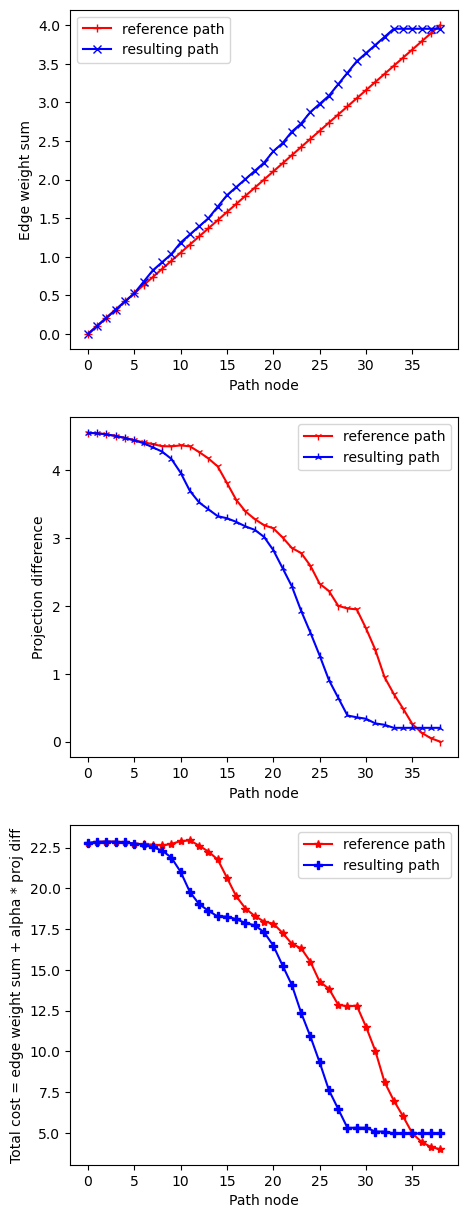

ALPHA = 10
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)

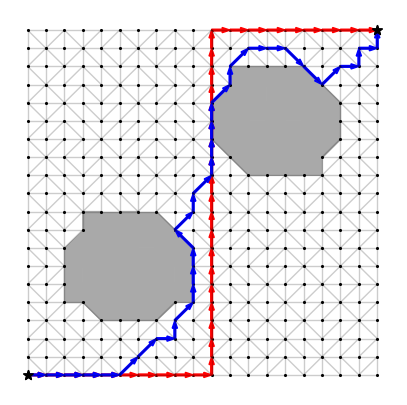

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


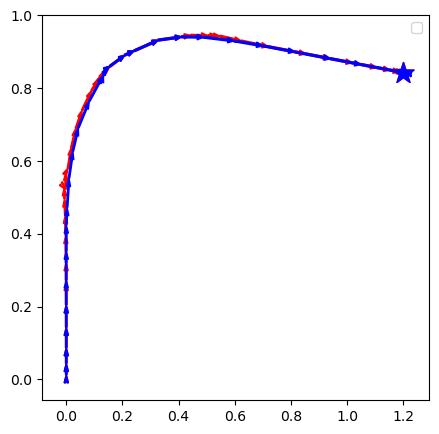

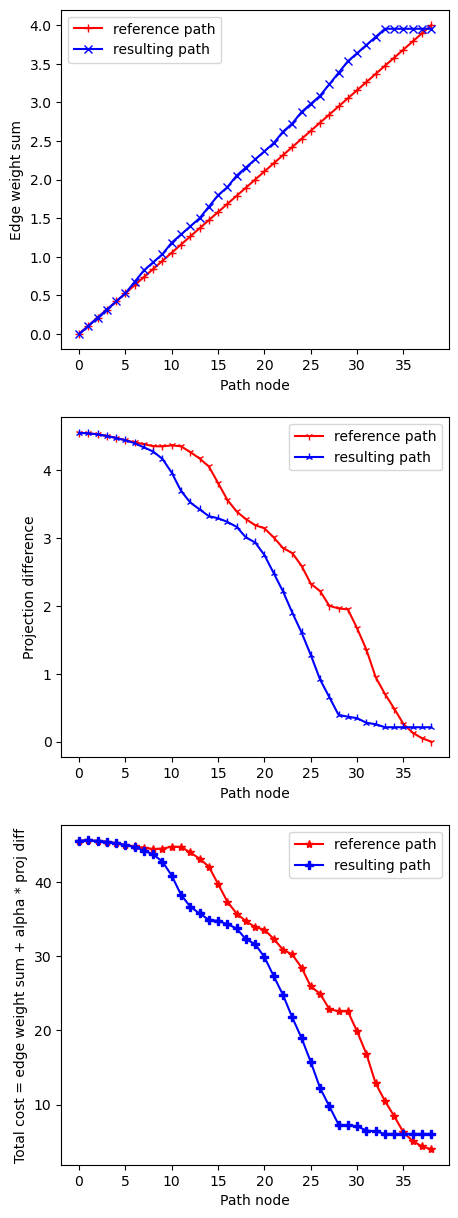

ALPHA = 100
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,

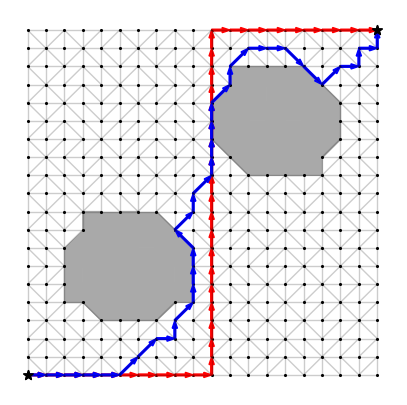

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


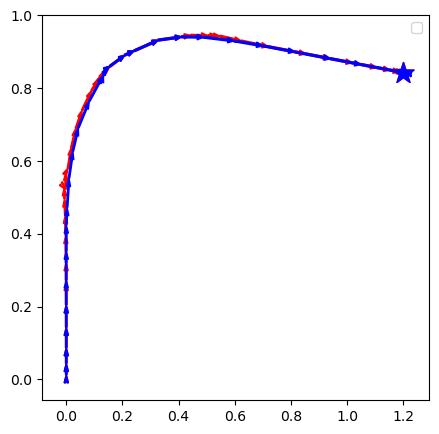

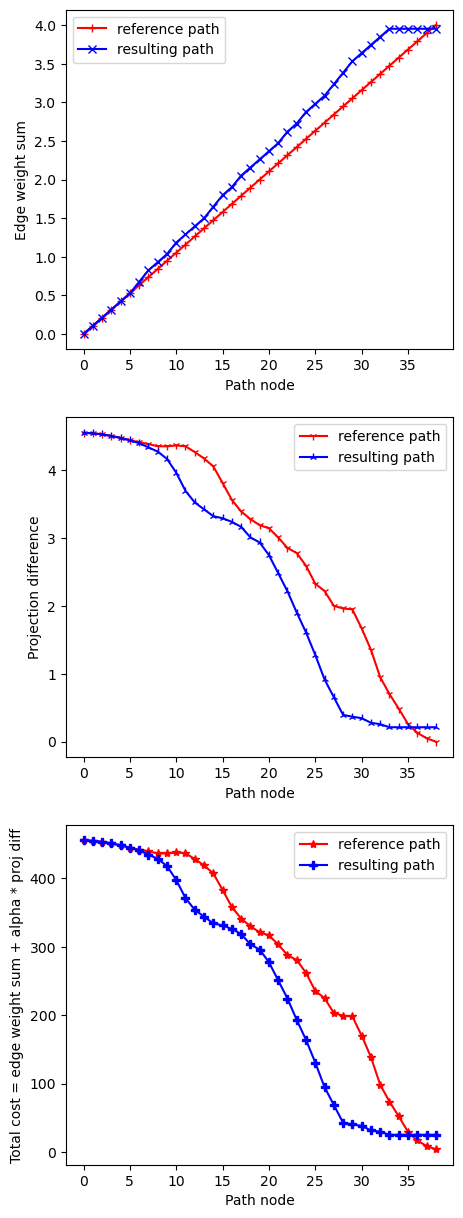

In [16]:
alphas = [0, 1, 5, 10, 100]

holders = []
for alpha in alphas:
        print(f"ALPHA = {alpha}")

        best_path, cost, prev, visit_order, other_paths = augmented_dijkstra(SC, start, end, ref_path_proj, alpha, False, extra)
        print(f"proj difference : {np.linalg.norm(ref_path_proj-best_path.edge_projections[-1],1)}")
        holder = dijkstra_tree(SC, best_path, other_paths, ref_path_class, plot_others=False)
        plot_cost_diffs(ref_path, best_path, ref_path_proj, alpha)
        print("---"*30)
        

# Alternate implementation

In [ ]:
def dijkstra_online(SC, start, end, ref_proj, k_radius, verbose=False, extra=False):
    
    def backtrace(prev, start, end):
        node = end
        path = []
        while node != start:
            path.append(node)
            node = prev[node]
        path.append(node) 
        path.reverse()
        return path
    
    def get_next_proj(u, v, curr_proj):
        edge = Trajectory(SC, [u,v], extra)
        proj = edge.edge_projections[1] # idx 0 is zero vec, idx 1 is edge proj
        next_proj = curr_proj + proj
        return next_proj

    def proj_cost(proj):
        proj_diff = proj - ref_proj
        return np.round(np.linalg.norm(proj_diff, 1), 8)

    def cost(u, v, proj):
        next_proj = get_next_proj(u, v, proj)
        proj_diff = proj_cost(next_proj)
        return next_proj, proj_diff
    
    dim_proj = SC.H_extra.shape[0] if extra else SC.H.shape[0]

    path = [start]

    curr_node = start
  
    G = SC.graph

    while curr_node != end:
        subgraph = nx.ego_graph(G, curr_node, k_radius, undirected=True)
        path, _, _, _, _ = augmented_dijkstra(SC, start, end, ref_path_proj, 1, beta=0)
        break

    return True

In [ ]:
def projection_descent(SC, curr_node, curr_proj, ref_proj):
    
    def proj_diff(proj):
        return np.linalg.norm(proj - ref_proj, ord=1)

    nodes_to_visit = 

    prev = {}
    dist = {v:np.inf for v in range(SC.node_vec.shape[0])}
    proj = {v:np.inf * np.ones(dim_proj) for v in range(SC.node_vec.shape[0])}
    edge_weight = {v:np.inf for v in range(SC.node_vec.shape[0])}
    visited = set()

    pq = pqdict()

    for i  in np.where(SC.node_vec == 1)[0]:
        pq[i] = float("inf") if (i != start) else 0

    dist[start], edge_weight[start], proj[start] = 0, 0, np.zeros(dim_proj)
    
    visit_order = []
    node_children = {node:0 for node in np.where(SC.node_vec == 1)[0]}
